In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import Dataset2 as Dataset
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from time import sleep, time
import datetime

from sklearn.metrics import confusion_matrix
import seaborn as sns

importlib.reload(Dataset)
DatasetContainer = Dataset.DatasetContainer
ProcessingDatasetContainer = Dataset.ProcessingDatasetContainer

def PLTParams(figsize = [15,15]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()

import sys
sys.path.append('../Code/')
plotSavePath = None
LogPath = '/remote/tychodata/ftairli/work/Projects/TrainingLogs/'

In [20]:
# Load Full Dataset
GlobalDataset = DatasetContainer()
Path_To_Data  = '/remote/tychodata/ftairli/data/Simulations__libraries__MCTask__Offline_v3r99p2a__IdealMC_CORSIKA__Hybrid_CORSIKA76400/SIB23c/DatasetFiles'
Path_To_Proc_Data = '.'
RunNames = ['Run010','Run030','Run080','Run090']
# RunNames = ['Run010']

GlobalDataset.Load(Path_To_Data+'/RawData',RunNames,LoadTraces=False)

Loading Run010
Loading Run030
Loading Run080
Loading Run090


In [21]:
def Mass_to_Class(Mass):
    if Mass == 2212 : return 0
    if Mass == 2004 : return 1
    if Mass == 8016 : return 2
    if Mass == 26056: return 3
    else: raise ValueError('Mass not recognised:',Mass)
    
def Class_to_Mass(Class):
    # Expect a torch tensor of classes scores
    if len(Class.shape) == 1: # we are dealing with Truth Tensor in form of classes
        Class = Class.unsqueeze(0)
    else: # Dealing with model predictions in form of scores for each class
        Class = torch.argmax(Class,dim=1) # Selects a class
    Mass = torch.zeros(Class.shape)
    for i in range(4):
        Mass[Class==i] = [2212,2004,8016,26056][i]
    return Mass

    
def Profile_Classifier_Data(Dataset,ProcessingDataset = None):
    '''Produces very simple structure to be used in this notebook
       Model Inputs  : dEdXmax,Xmax,UspR,UspL
       Model Outputs : Mass (As Classification)
       For MetaData  : Nothing?'''
    
    IDsList = ()
    Main   = []
    Aux    = []
    Truth  = []
    Rec    = []
    Meta   = []
    for i, Event in enumerate(Dataset):
        ID = (Event.get_value('EventID_1/2').int()*100000 + Event.get_value('EventID_2/2').int()).item()
        IDsList += (ID,)
        if True and i%100==0 :
            print('Processing Event:',i,'/',len(Dataset),end = '\r')

        dEdXmax = Event.get_value('Rec_dEdXmax')
        Xmax    = Event.get_value('Rec_Xmax')
        UspR    = Event.get_value('Rec_UspR')
        UspL    = Event.get_value('Rec_UspL')
        Mass    = Event.get_value('Primary')
        Mass    = Mass_to_Class(Mass)
        
        # Normalisation
        dEdXmax = (np.log10(dEdXmax)-1.12 ) / 0.59
        Xmax    = (Xmax             - 750 ) / 62
        UspR    = (UspR             - 0.25) / 0.026
        UspL    = (UspL             - 234 ) / 8.67
        
        # Append
        Main  .append(torch.tensor([dEdXmax,Xmax,UspR,UspL]))
        Aux   .append(torch.tensor([                      ]))
        Truth .append(torch.tensor([Mass                  ]))
        Rec   .append(torch.tensor([                      ]))
        Meta  .append(torch.tensor([                      ]))

    # Stack
    Main = torch.stack(Main)
    Aux  = torch.stack(Aux)
    Truth = torch.stack(Truth)
    Rec = torch.stack(Rec)
    Meta = torch.stack(Meta)

    if ProcessingDataset is None:
        return Main,Aux,Truth,Rec,Meta,IDsList
    
    else:
        ProcessingDataset._Main     = (Main,)
        ProcessingDataset._Aux      = Aux
        ProcessingDataset._Truth    = Truth
        ProcessingDataset._Rec      = Rec
        ProcessingDataset._MetaData = Meta
        
        ProcessingDataset.Unnormalise_Truth = Class_to_Mass
        ProcessingDataset.Truth_Keys        = ['Mass']
        ProcessingDataset.Truth_Units       = ['']
        
        if ProcessingDataset._EventIds is None:
            ProcessingDataset._EventIds = IDsList
        else:
            assert ProcessingDataset._EventIds == IDsList, 'Event IDs do not match'

Calculate = True
if Calculate:
    ProcDS = ProcessingDatasetContainer()

    Profile_Classifier_Data(GlobalDataset,ProcessingDataset=ProcDS)
    torch.save(ProcDS,Path_To_Proc_Data+'/ProfileClassifierData.pt')
else:
    ProcDS = torch.load(Path_To_Proc_Data+'/ProfileClassifierData.pt')
    


In [134]:
Usp_R = GlobalDataset.get_values('Rec_UspR')
Usp_L = GlobalDataset.get_values('Rec_UspL')
Xmax  = GlobalDataset.get_values('Rec_Xmax')

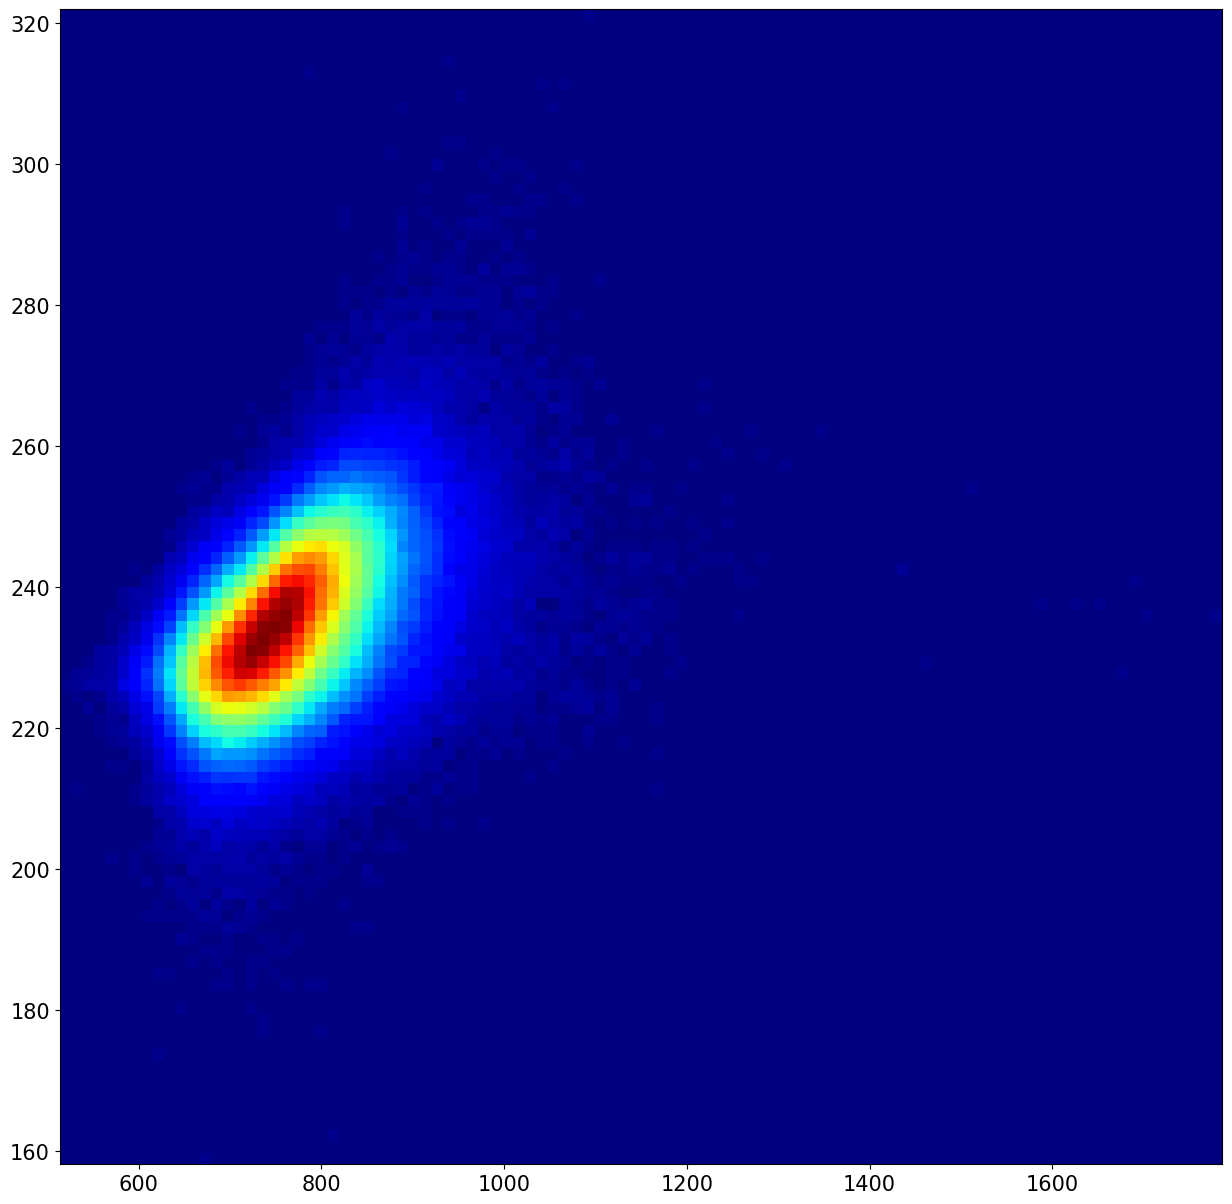

In [140]:
plt.figure(figsize=[15,15])
plt.hist2d(Xmax.numpy(),Usp_L.numpy(),bins=100,cmap='jet',norm=mcolors.PowerNorm(0.5))
plt.show()

In [22]:
# Define Loss, Validate and Metric Functions
def Loss(Pred,Truth,keys = ['Mass'],ReturnTensor = True):
    '''
    Calculates CrossEntropy Loss for all the keys in the keys list
    '''
    assert len(Pred) == len(Truth), 'Prediction and Truth have different lengths'

    Truth = Truth.to(Pred.device).long().squeeze()

    losses = {}
    if 'Mass' in keys:
        losses['Mass'] = F.cross_entropy(Pred,Truth)
    else:
        for i,key in enumerate(keys):
            losses[key] = F.cross_entropy(Pred[:,i],Truth[:,i])
    
    losses['Total'] = sum(losses.values())
    if ReturnTensor: return losses
    else:
        losses = {key:loss.item() for key,loss in losses.items()}
        return losses

def validate(model,Dataset,Loss,device,BatchSize = 256):
    '''
    Takes model, Dataset, Loss Function, device, keys
    Dataset is defined as ProcessingDatasetContainer in the Dataset2.py
    keys are to be used in the loss function
    BatchSize to change in case it doesnt fit into memory
    Returns the average loss
    '''
    # make sure the Dataset State is Val
    Dataset.State = 'Val'
    model.eval()
    TrainingBatchSize = Dataset.BatchSize
    Dataset.BatchSize = BatchSize
    Preds  = []
    Truths = []
    with torch.no_grad():
        for _, BatchMains, BatchAux, BatchTruth,_  in Dataset:
            
            Preds .append( model(BatchMains,BatchAux).to('cpu'))
            Truths.append(       BatchTruth          .to('cpu'))
        Preds  = torch.cat(Preds ,dim=0)
        Truths = torch.cat(Truths,dim=0)

    # Return Batch Size to old value
    Dataset.BatchSize = TrainingBatchSize
    return Loss(Preds,Truths,keys=Dataset.Truth_Keys,ReturnTensor=False)

def metric(model,Dataset,device,keys = ['Mass'],BatchSize = 256):
    '''
    There really isnt a metric that i can make up, its just the loss really so return zeros for every key
    '''
    metrics={}
    for i, key in enumerate(keys):
        metrics[key] = 0
    return metrics



In [63]:
class Model_Mass_Classifier(nn.Module):
    def __init__(self, in_main_channels = 4, in_aux_channels = 0, out_channels = 4, N_dense_nodes = 128,**kwargs):
        self.Name = 'Model_Mass_Classifier'
        self.Description = 'Simple Model for Mass Classification'
        self.kwargs = kwargs
        super(Model_Mass_Classifier, self).__init__()

        if type(in_main_channels) != int:
            in_main_channels = in_main_channels[0]
        self.fc1 = nn.Linear(in_main_channels, N_dense_nodes)
        self.fc2 = nn.Linear(N_dense_nodes, N_dense_nodes)
        self.fc3 = nn.Linear(N_dense_nodes, N_dense_nodes)
        self.fc4 = nn.Linear(N_dense_nodes, N_dense_nodes)
        self.fc5 = nn.Linear(N_dense_nodes, N_dense_nodes)
        self.fc_out = nn.Linear(N_dense_nodes, out_channels)


        self.Activation    = nn.ReLU()
        self.OutActivation = nn.Softmax(dim=1)

    def forward(self, Main, Aux):
        Main = Main[0]
        Main = Main.to(self.fc1.weight.device)
        x = self.Activation(self.fc1(Main))
        x = self.Activation(self.fc2(x))
        x = self.Activation(self.fc3(x))
        x = self.Activation(self.fc4(x))
        x = self.Activation(self.fc5(x))
        x = self.OutActivation(self.fc_out(x))
        return x

class Model_Mass_Classifier_OnlyXmax(nn.Module):
    def __init__(self, in_main_channels = 4, in_aux_channels = 0, out_channels = 4, N_dense_nodes = 128,**kwargs):
        self.Name = 'Model_Mass_Classifier_OnlyXmax'
        self.Description = 'Simple Model for Mass Classification'
        self.kwargs = kwargs
        super(Model_Mass_Classifier_OnlyXmax, self).__init__()

        if type(in_main_channels) != int:
            in_main_channels = in_main_channels[0]
        self.fc1 = nn.Linear(in_main_channels, N_dense_nodes)
        self.fc2 = nn.Linear(N_dense_nodes, N_dense_nodes)
        self.fc3 = nn.Linear(N_dense_nodes, N_dense_nodes)
        self.fc4 = nn.Linear(N_dense_nodes, N_dense_nodes)
        self.fc5 = nn.Linear(N_dense_nodes, N_dense_nodes)
        self.fc_out = nn.Linear(N_dense_nodes, out_channels)


        self.Activation    = nn.ReLU()
        self.OutActivation = nn.Softmax(dim=1)

    def forward(self, Main, Aux):
        Main = Main[0]
        Main[:,[0,2,3]] = 0
        Main = Main.to(self.fc1.weight.device)
        x = self.Activation(self.fc1(Main))
        x = self.Activation(self.fc2(x))
        x = self.Activation(self.fc3(x))
        x = self.Activation(self.fc4(x))
        x = self.Activation(self.fc5(x))
        x = self.OutActivation(self.fc_out(x))
        return x

In [ ]:
def Process(Model,ProcDS):
    Truths = []
    Preds  = []
    ProcDS.State = 'Test'
    with torch.no_grad():
        for _, BatchMains, BatchAux, BatchTruth,_  in ProcDS:
            Preds .append(Model(BatchMains,BatchAux).to('cpu'))
            Truths.append(      BatchTruth          .to('cpu'))
    
    Preds  = torch.cat(Preds ,dim=0)
    Truths = torch.cat(Truths,dim=0)

    ProcDS.Unnormalise_Truth(Truths)
    ProcDS.Unnormalise_Truth(Preds)
    
    Preds  = Preds .numpy()
    Truths = Truths.numpy()
    return Preds,Truths


In [64]:
# Load the model and axuillary functions
import TrainingModule
importlib.reload(TrainingModule)
Tracker = TrainingModule.Tracker
Train   = TrainingModule.Train


ProcDS.AssignIndices()
ProcDS.BatchSize = 256
ProcDS.RandomIter = True

Loss_function = Loss

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Model_Parameters = {
            'in_main_channels': (4,),
            'in_node_channels': 7   ,
            'in_edge_channels': 3   ,
            'in_aux_channels' : 1   ,
            'N_kernels'       : 32  ,
            'N_heads'         : 4   ,
            'N_dense_nodes'   : 128 ,
            'N_LSTM_nodes'    : 64  ,
            'N_LSTM_layers'   : 5   ,
            'kernel_size'     : 10  ,
            'conv2d_init_type': 'normal',
            'dropout'         : 0
        }
        
Training_Parameters = {
            'LR': 0.0001,
            'epochs': 10,
            'BatchSize': 256,
            'accumulation_steps': 1,
            'epoch_done': 0,
            'batchBreak': 1e99,
            'ValLossIncreasePatience': 15,
            'Optimizer': 'Adam'
        }



### Below is with All variables

#### Training and Processing

In [110]:
# Train or load
Load_Name = 'Model_Mass_Classifier_2024-12-18_13-32-44.pt'
if Load_Name is not None:
    model = torch.load(Load_Name)
else:
    model = Model_Mass_Classifier(**Model_Parameters).to(device)
    if Training_Parameters['Optimizer'] == 'Adam': optimizer = optim.Adam(model.parameters(), lr=Training_Parameters['LR'])
    if Training_Parameters['Optimizer'] == 'SGD' : optimizer = optim.SGD (model.parameters(), lr=Training_Parameters['LR'], momentum=0.9)
    # Define scheduler
    gamma = 0.001**(1/30) if Training_Parameters['epochs']>30 else 0.001**(1/Training_Parameters['epochs']) # Reduce the LR by factor of 1000 over 30 epochs or less
    scheduler = torch.optim.lr_scheduler.ExponentialLR    (optimizer, gamma = gamma, last_epoch=-1, verbose=False)

    ProcDS.BatchSize = Training_Parameters['BatchSize'] # Explicitly assign here


    ProcDS.BatchSize = Training_Parameters['BatchSize'] # Explicitly assign here
    model,tracker = Train(model,ProcDS,optimizer,scheduler,Loss_function,validate,metric ,Tracker,device = device,\
                        plotOnEpochCompletionPath=plotSavePath,Training_Parameters=Training_Parameters,Model_Parameters=Model_Parameters,LogPath=LogPath)

In [111]:
# After Training Save Model
if Load_Name is None:
    Date_and_Time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    print('Saving Model as:',Date_and_Time)

    torch.save(model,f'./{model.Name}_{Date_and_Time}.pt')

In [112]:
# Process the model

Preds,Truths = Process(model,ProcDS)
# Calculate Metrics

Accuracy = np.sum(Truths == Preds) / len(Truths)
print('Model Name = ',model.Name)
print('Accuracy:',Accuracy)

Model Name =  Model_Mass_Classifier
Accuracy: 0.4887374229146381


#### Plots

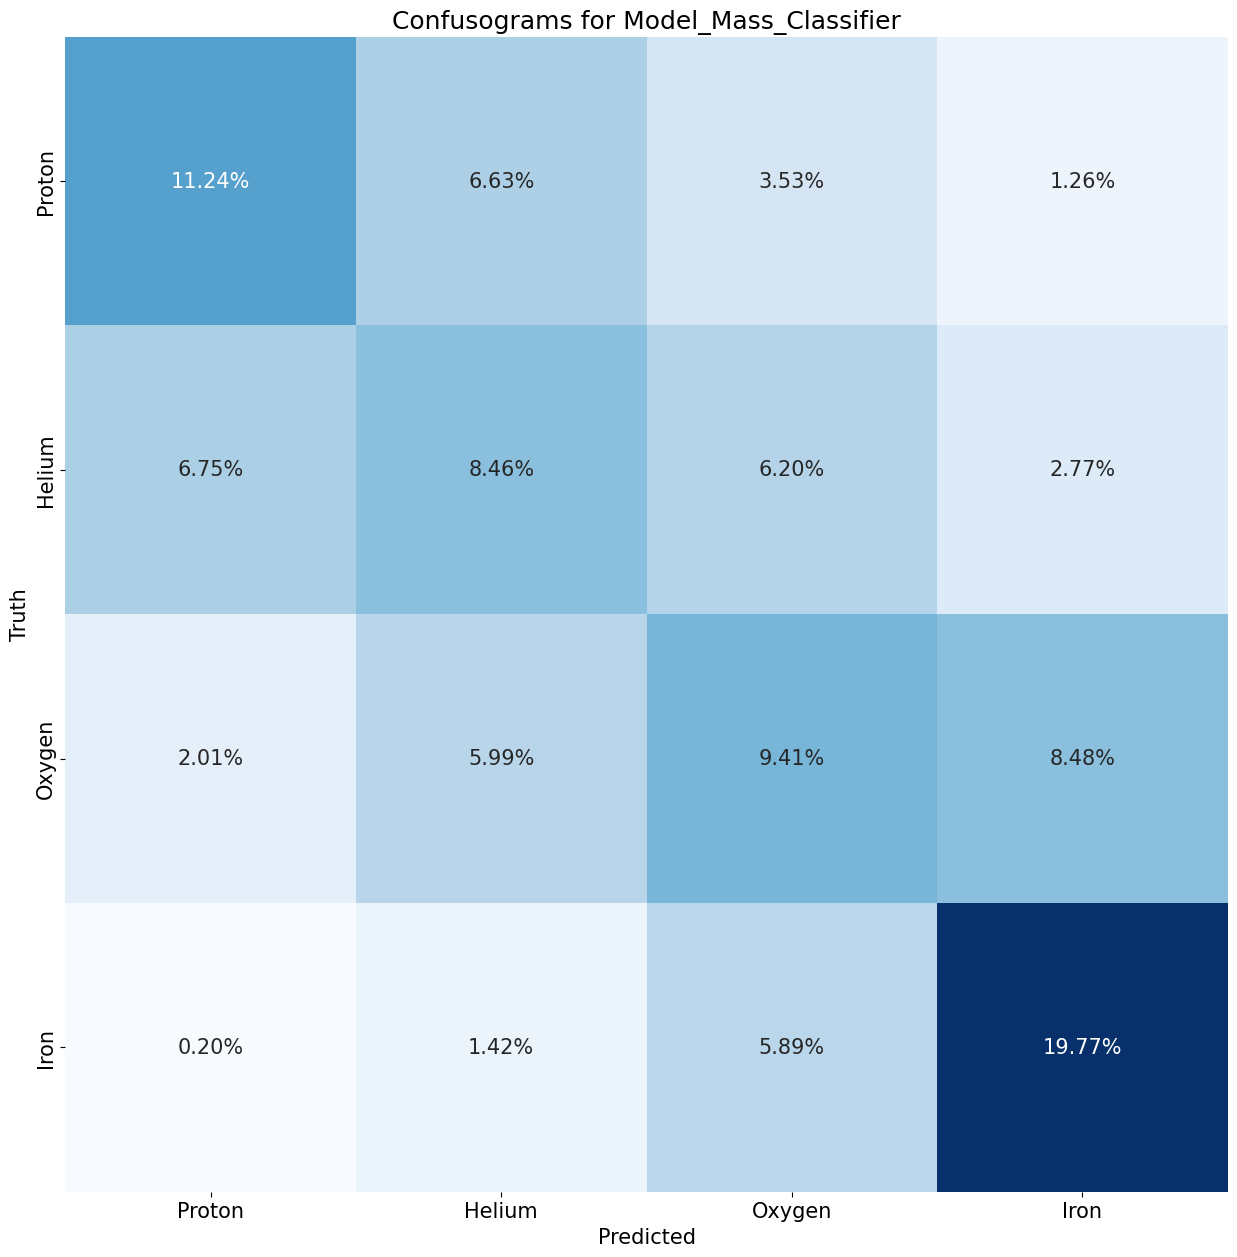

In [113]:
if not 'OnlyXmax' in model.Name:
    # Compute the confusion matrix
    cm = confusion_matrix(Truths, Preds)

    # Plot the confusion matrix
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues',cbar=False)
    # Rename the ticks
    plt.xticks(ticks=[0.5,1.5,2.5,3.5], labels=['Proton','Helium','Oxygen','Iron'])
    plt.yticks(ticks=[0.5,1.5,2.5,3.5], labels=['Proton','Helium','Oxygen','Iron'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f'Confusograms for {model.Name}')

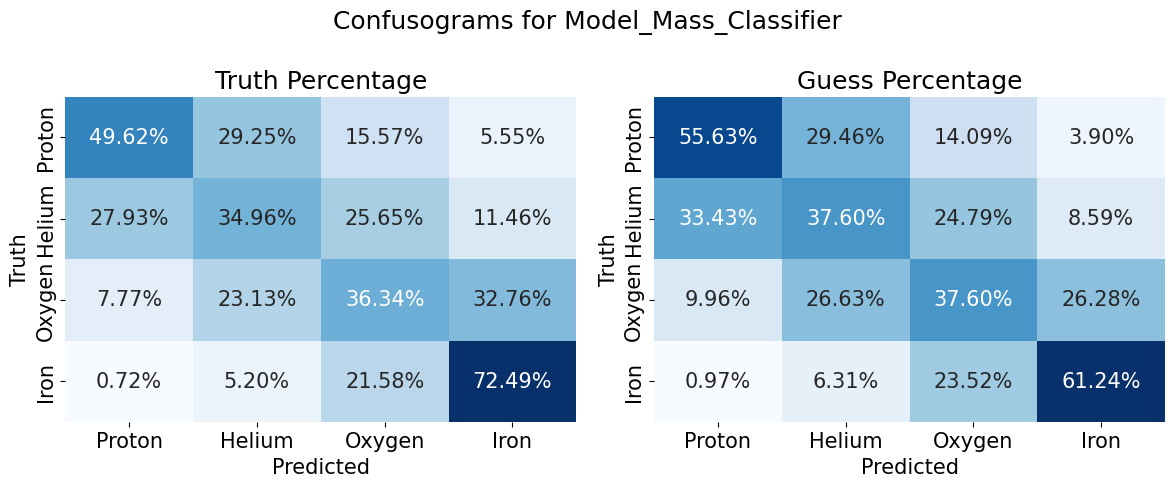

In [114]:
if not 'OnlyXmax' in model.Name:
    # Compute the confusion matrix
    cm = confusion_matrix(Truths, Preds)

    # Normalize by rows (Truth Percentage)
    cm_truth_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Normalize by columns (Guess Percentage)
    cm_guess_percentage = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]

    # Plot the Truth Percentage matrix
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm_truth_percentage, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.title('Truth Percentage')
    plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=['Proton', 'Helium', 'Oxygen', 'Iron'])
    plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=['Proton', 'Helium', 'Oxygen', 'Iron'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

    # Plot the Guess Percentage matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_guess_percentage, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.title('Guess Percentage')
    plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=['Proton', 'Helium', 'Oxygen', 'Iron'])
    plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=['Proton', 'Helium', 'Oxygen', 'Iron'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.suptitle(f'Confusograms for {model.Name}')
    plt.tight_layout()
    plt.show()


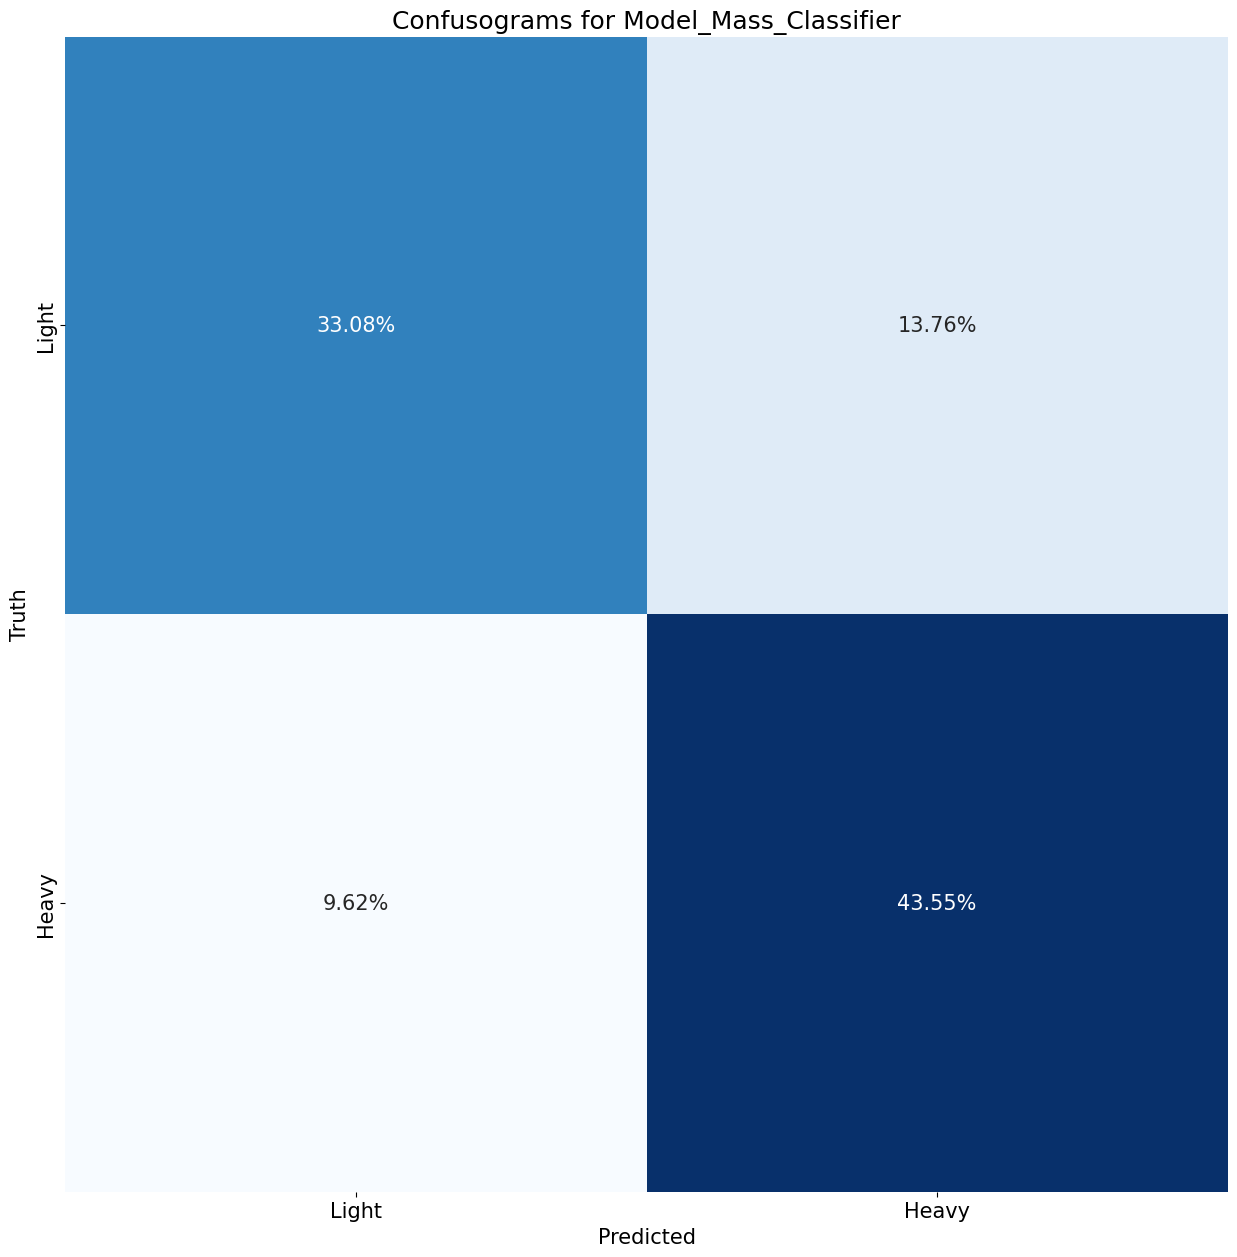

In [115]:
# Light-Heavy Split plot, just summs confusion matrix to get the light-heavy split

if not 'OnlyXmax' in model.Name:
    # Compute the confusion matrix
    cm = confusion_matrix(Truths, Preds)
    new_cm = np.zeros((2,2))
    new_cm[0,0] = np.sum(cm[0:2,0:2])
    new_cm[0,1] = np.sum(cm[0:2,2:4])
    new_cm[1,0] = np.sum(cm[2:4,0:2])
    new_cm[1,1] = np.sum(cm[2:4,2:4])


    # Plot the confusion matrix
    sns.heatmap(new_cm/np.sum(new_cm), annot=True, fmt='.2%', cmap='Blues',cbar=False)
    # Rename the ticks
    plt.xticks(ticks=[0.5,1.5], labels=['Light','Heavy'])
    plt.yticks(ticks=[0.5,1.5], labels=['Light','Heavy'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f'Confusograms for {model.Name}')


### Below is Just Xmax

#### Training and Processing

In [116]:
# Train or load model
Load_Name = 'Model_Mass_Classifier_OnlyXmax_2024-12-18_13-38-48.pt'
if Load_Name is not None:
    model = torch.load(Load_Name)
else:
    # Train The Xmax Only model
    model = Model_Mass_Classifier_OnlyXmax(**Model_Parameters).to(device)
    if Training_Parameters['Optimizer'] == 'Adam': optimizer = optim.Adam(model.parameters(), lr=Training_Parameters['LR'])
    if Training_Parameters['Optimizer'] == 'SGD' : optimizer = optim.SGD (model.parameters(), lr=Training_Parameters['LR'], momentum=0.9)
    # Define scheduler
    gamma = 0.001**(1/30) if Training_Parameters['epochs']>30 else 0.001**(1/Training_Parameters['epochs']) # Reduce the LR by factor of 1000 over 30 epochs or less
    scheduler = torch.optim.lr_scheduler.ExponentialLR    (optimizer, gamma = gamma, last_epoch=-1, verbose=False)

    ProcDS.BatchSize = Training_Parameters['BatchSize'] # Explicitly assign here


    ProcDS.BatchSize = Training_Parameters['BatchSize'] # Explicitly assign here
    model,tracker = Train(model,ProcDS,optimizer,scheduler,Loss_function,validate,metric ,Tracker,device = device,\
                        plotOnEpochCompletionPath=plotSavePath,Training_Parameters=Training_Parameters,Model_Parameters=Model_Parameters,LogPath=LogPath)

In [117]:
# After Training Save Model
if Load_Name is None:
    Date_and_Time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    print('Saving Model as:',Date_and_Time)

    torch.save(model,f'./{model.Name}_{Date_and_Time}.pt')

In [118]:
# Process the model

Preds,Truths = Process(model,ProcDS)
# Calculate Metrics

Accuracy = np.sum(Truths == Preds) / len(Truths)
print('Model Name = ',model.Name)
print('Accuracy:',Accuracy)

Model Name =  Model_Mass_Classifier_OnlyXmax
Accuracy: 0.40730282375851995


#### PLots

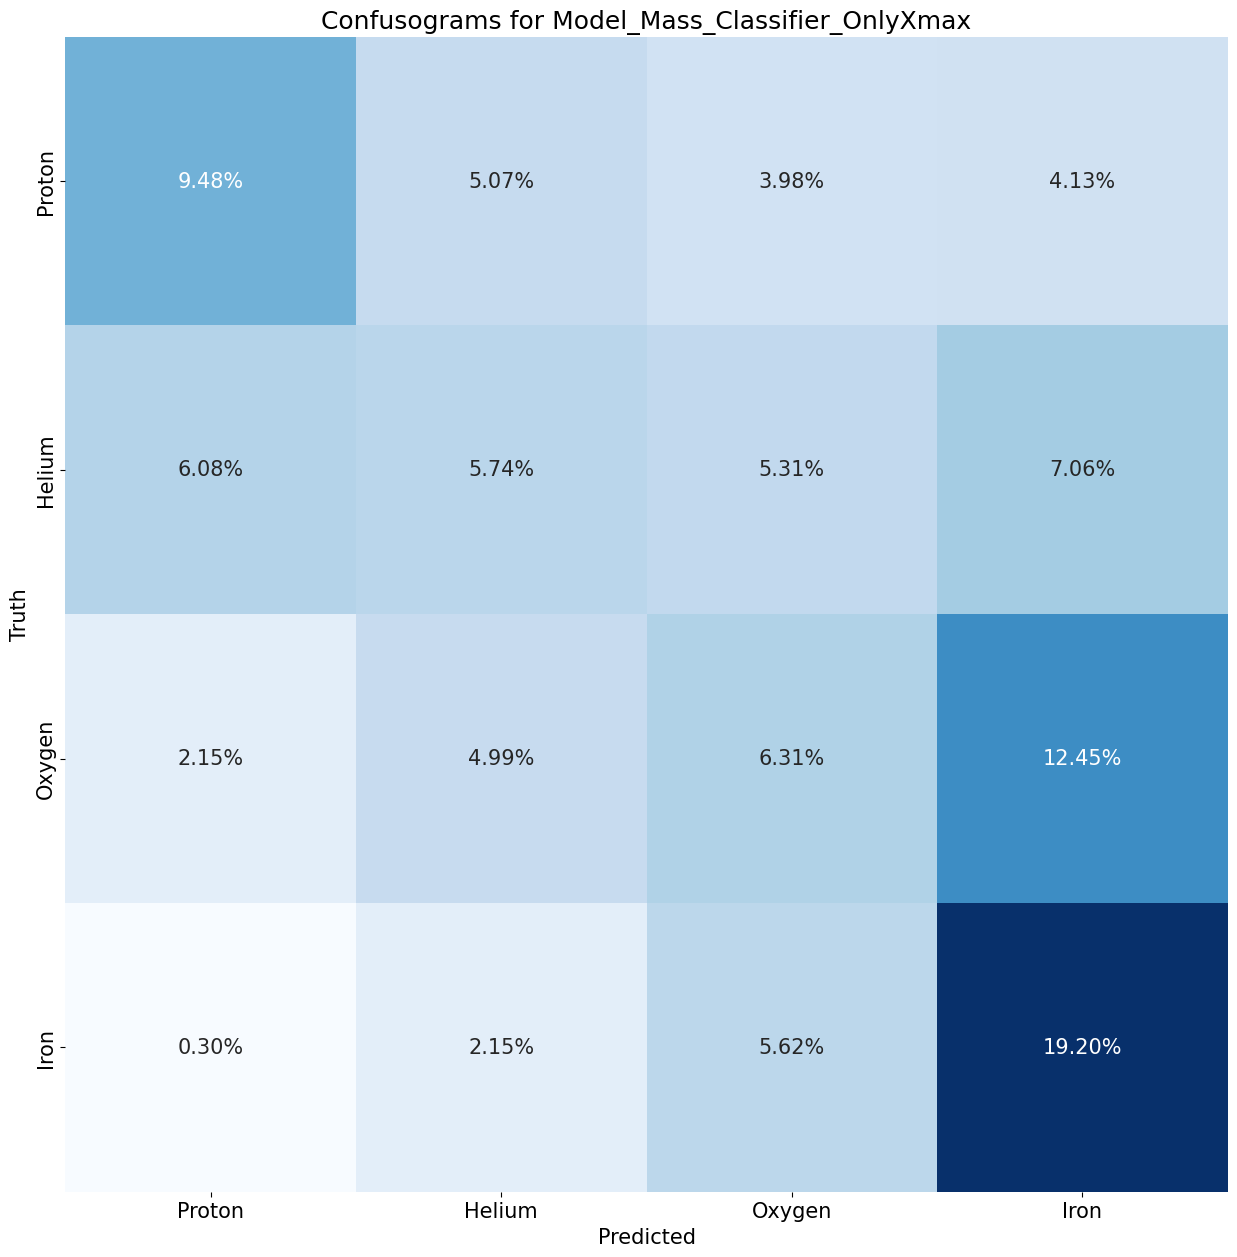

In [119]:
if 'OnlyXmax' in model.Name:
    # Compute the confusion matrix
    cm = confusion_matrix(Truths, Preds)

    # Plot the confusion matrix
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues',cbar=False)
    # Rename the ticks
    plt.xticks(ticks=[0.5,1.5,2.5,3.5], labels=['Proton','Helium','Oxygen','Iron'])
    plt.yticks(ticks=[0.5,1.5,2.5,3.5], labels=['Proton','Helium','Oxygen','Iron'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f'Confusograms for {model.Name}')

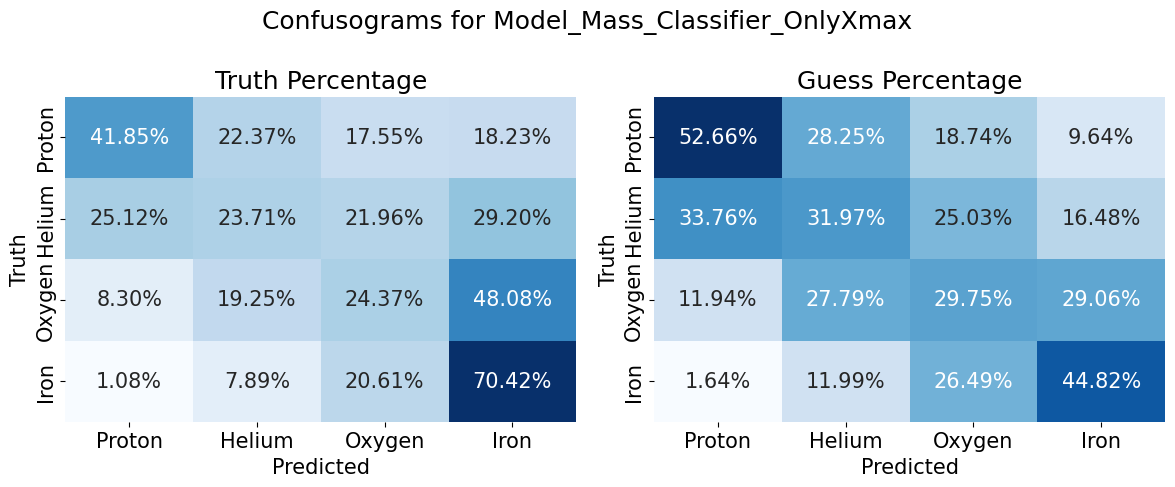

In [120]:
if 'OnlyXmax' in model.Name:
    # Compute the confusion matrix
    cm = confusion_matrix(Truths, Preds)

    # Normalize by rows (Truth Percentage)
    cm_truth_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Normalize by columns (Guess Percentage)
    cm_guess_percentage = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]

    # Plot the Truth Percentage matrix
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm_truth_percentage, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.title('Truth Percentage')
    plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=['Proton', 'Helium', 'Oxygen', 'Iron'])
    plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=['Proton', 'Helium', 'Oxygen', 'Iron'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

    # Plot the Guess Percentage matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_guess_percentage, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.title('Guess Percentage')
    plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=['Proton', 'Helium', 'Oxygen', 'Iron'])
    plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=['Proton', 'Helium', 'Oxygen', 'Iron'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.suptitle(f'Confusograms for {model.Name}')
    plt.tight_layout()
    plt.show()


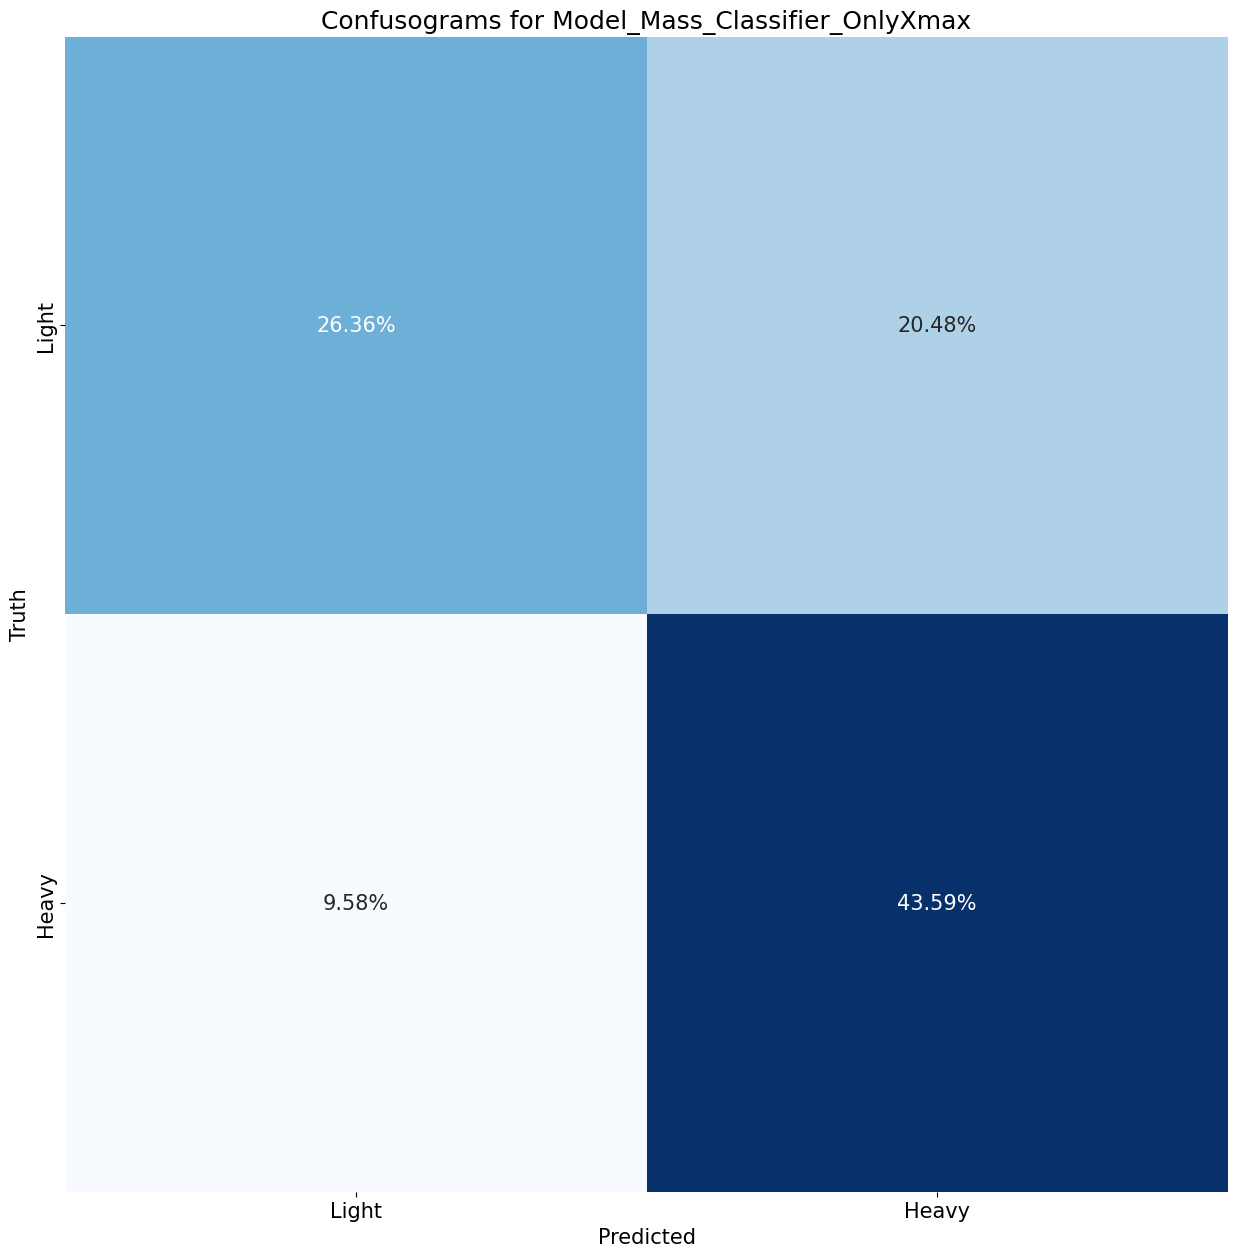

In [121]:
# Light-Heavy Split plot, just summs confusion matrix to get the light-heavy split

if 'OnlyXmax' in model.Name:
    # Compute the confusion matrix
    cm = confusion_matrix(Truths, Preds)
    new_cm = np.zeros((2,2))
    new_cm[0,0] = np.sum(cm[0:2,0:2])
    new_cm[0,1] = np.sum(cm[0:2,2:4])
    new_cm[1,0] = np.sum(cm[2:4,0:2])
    new_cm[1,1] = np.sum(cm[2:4,2:4])


    # Plot the confusion matrix
    sns.heatmap(new_cm/np.sum(new_cm), annot=True, fmt='.2%', cmap='Blues',cbar=False)
    # Rename the ticks
    plt.xticks(ticks=[0.5,1.5], labels=['Light','Heavy'])
    plt.yticks(ticks=[0.5,1.5], labels=['Light','Heavy'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f'Confusograms for {model.Name}')

### Cuts Plot (Not interesting?)

/tmp/ipykernel_26531/2152393892.py:24: RuntimeWarning: invalid value encountered in divide
  cm_truth_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


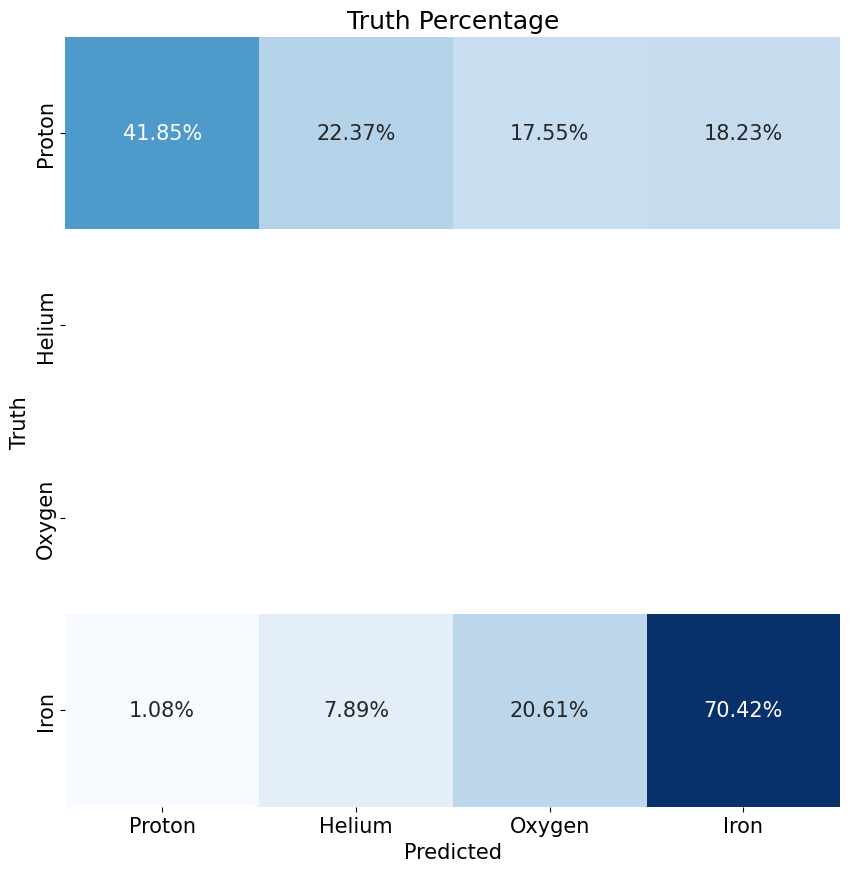

In [122]:
# Remove the Helium and Oxygen Events
TrueProtonMask = Truths == 0
TrueIronMask   = Truths == 3
PredProtonMask = Preds  == 0
PredIronMask   = Preds  == 3

TrueMask = TrueProtonMask | TrueIronMask
PredMask = PredProtonMask | PredIronMask


# Remove Events that are not predicted as Proton or Iron
# cut_Truths = Truths[PredMask]#  & TrueMask]
# cut_Preds  = Preds [PredMask]#  & TrueMask]

cut_Truths = Truths[TrueMask]
cut_Preds  = Preds [TrueMask]


# Compute the confusion matrix
cm = confusion_matrix(cut_Truths, cut_Preds)

# Normalize by columns (Truth Percentage)
cm_guess_percentage = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
cm_truth_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize = (10,10))
sns.heatmap(cm_truth_percentage, annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.title('Truth Percentage')
plt.xticks(ticks=[0.5,1.5,2.5,3.5], labels=['Proton','Helium','Oxygen','Iron'])
plt.yticks(ticks=[0.5,1.5,2.5,3.5], labels=['Proton','Helium','Oxygen','Iron'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [123]:
# Load Every model, Process, and print the metrics

Model_Names = [Full_Model_Trained_Once,Full_Model_Trained_Twice,Xmax_Model_Trained_Once,Xmax_Model_Trained_Twice]

for Model_Name in Model_Names:
    model = torch.load(Model_Name)
    Preds,Truths = Process(model,ProcDS)
    Accuracy = np.sum(Truths == Preds) / len(Truths)
    print('Model:',model.Name)
    print('Accuracy:',Accuracy)
    print()

Model: Model_Mass_Classifier
Accuracy: 0.4894677052904901

Model: Model_Mass_Classifier
Accuracy: 0.4894677052904901

Model: Model_Mass_Classifier_OnlyXmax
Accuracy: 0.4025154170723791

Model: Model_Mass_Classifier_OnlyXmax
Accuracy: 0.4023855890944499

